# Case3: PyTorch Lightning Implementation of a MLP + Ensemble Learning for Risk Score Prediction

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm as tqdm
import argparse

# import prediction model
from models import RiskScoreEnsembleModel_PL

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchmetrics import Accuracy

# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import EarlyStopping, RichProgressBar

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [2]:
# prase hyperparameters
parser = argparse.ArgumentParser(description='MLP_Ensemble')
parser.add_argument('--batch-size', default=32, type=int, metavar='N',
                    help='batch size for training')
parser.add_argument('--num-models', default=5, type=int, metavar='N',
                    help='number of models for ensemble learning')
parser.add_argument('--hidden-size', default=128, type=int, metavar='N',
                    help='hidden size of MLP')
parser.add_argument('--epochs', default=100, type=int, metavar='N',
                    help='number of total epochs for training')
parser.add_argument('--lr', default=1e-3, type=float, metavar='LR',
                    help='learning rate')

# if you run argparse in jupyter notebook:
args = parser.parse_args(args=[])

# # if you run argparse in .py file:
# args = parser.parse_args()

parser.print_help()

usage: ipykernel_launcher.py [-h] [--batch-size N] [--num-models N]
                             [--hidden-size N] [--epochs N] [--lr LR]

MLP_Ensemble

optional arguments:
  -h, --help       show this help message and exit
  --batch-size N   batch size for training
  --num-models N   number of models for ensemble learning
  --hidden-size N  hidden size of MLP
  --epochs N       number of total epochs for training
  --lr LR          learning rate


## Data Preprocessing

In [3]:
# training data
df = pd.read_csv('New Risk Score ML Training Data.csv')

df_len = len(df) # number of rows
print(f"Number of rows: {df_len}")

# display the first 5 rows
df.head()

Number of rows: 2000


,Name,Risk Score,Bachelor's Degree,Master's Degree,More Than 5 Years of Work Experience,More Than 10 Years of Work Experience,More Than 15 Years of Work Experience,More Than 20 Years of Work Experience,More Than 25 Years of Work Experience,More Than 30 Years of Work Experience,...,Industry Sanctions & Other Legal Actions,Professional Licenses,LinkedIn Potential Controversies,LinkedIn Political Activity,Twitter Potential Controversies,Twitter Political Activity,Facebook Potential Controversies,Facebook Political Activity,Instagram Potential Controversies,Instagram Political Activity
0,Anthony Ivy,5,Yes,Yes,Yes,Yes,No,No,No,No,...,No,No,No,No,No,No,No,No,No,No
1,Blaise Carroz,5,Yes,No,Yes,Yes,Yes,Yes,No,No,...,No,No,No,No,No,No,No,No,No,No
2,Callie Thomas,1,Yes,No,Yes,Yes,Yes,Yes,No,No,...,No,No,No,No,No,No,No,No,No,No
3,Campbell Murray,3,Yes,Yes,Yes,Yes,Yes,Yes,No,No,...,No,No,No,Yes,No,No,No,No,No,No
4,Daniel Beck,3,Yes,No,Yes,Yes,Yes,No,No,No,...,No,No,No,No,No,No,No,No,No,No


In [4]:
# make the 1st column the index
df = df.set_index('Name')

# display the first 5 rows
df.head()

,Risk Score,Bachelor's Degree,Master's Degree,More Than 5 Years of Work Experience,More Than 10 Years of Work Experience,More Than 15 Years of Work Experience,More Than 20 Years of Work Experience,More Than 25 Years of Work Experience,More Than 30 Years of Work Experience,Years of Work Experience,...,Industry Sanctions & Other Legal Actions,Professional Licenses,LinkedIn Potential Controversies,LinkedIn Political Activity,Twitter Potential Controversies,Twitter Political Activity,Facebook Potential Controversies,Facebook Political Activity,Instagram Potential Controversies,Instagram Political Activity
Name,,,,,,,,,,,,,,,,,,,,,
Anthony Ivy,5,Yes,Yes,Yes,Yes,No,No,No,No,13,...,No,No,No,No,No,No,No,No,No,No
Blaise Carroz,5,Yes,No,Yes,Yes,Yes,Yes,No,No,21,...,No,No,No,No,No,No,No,No,No,No
Callie Thomas,1,Yes,No,Yes,Yes,Yes,Yes,No,No,23,...,No,No,No,No,No,No,No,No,No,No
Campbell Murray,3,Yes,Yes,Yes,Yes,Yes,Yes,No,No,23,...,No,No,No,Yes,No,No,No,No,No,No
Daniel Beck,3,Yes,No,Yes,Yes,Yes,No,No,No,17,...,No,No,No,No,No,No,No,No,No,No


In [5]:
# convert Yes or No to 1 or 0 from the 2nd column to the last column
df.iloc[:, 1:] = df.iloc[:, 1:].replace({'Yes': 1, 'No': 0})

# display the first 5 rows
df.head()

,Risk Score,Bachelor's Degree,Master's Degree,More Than 5 Years of Work Experience,More Than 10 Years of Work Experience,More Than 15 Years of Work Experience,More Than 20 Years of Work Experience,More Than 25 Years of Work Experience,More Than 30 Years of Work Experience,Years of Work Experience,...,Industry Sanctions & Other Legal Actions,Professional Licenses,LinkedIn Potential Controversies,LinkedIn Political Activity,Twitter Potential Controversies,Twitter Political Activity,Facebook Potential Controversies,Facebook Political Activity,Instagram Potential Controversies,Instagram Political Activity
Name,,,,,,,,,,,,,,,,,,,,,
Anthony Ivy,5,1,1,1,1,0,0,0,0,13,...,0,0,0,0,0,0,0,0,0,0
Blaise Carroz,5,1,0,1,1,1,1,0,0,21,...,0,0,0,0,0,0,0,0,0,0
Callie Thomas,1,1,0,1,1,1,1,0,0,23,...,0,0,0,0,0,0,0,0,0,0
Campbell Murray,3,1,1,1,1,1,1,0,0,23,...,0,0,0,1,0,0,0,0,0,0
Daniel Beck,3,1,0,1,1,1,0,0,0,17,...,0,0,0,0,0,0,0,0,0,0


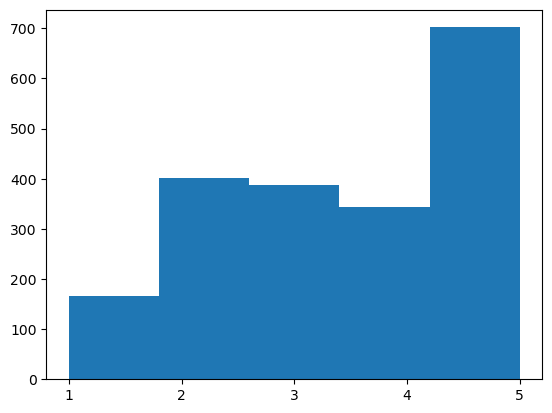

In [6]:
# class distribution
plt.hist(df['Risk Score'], bins=len(df['Risk Score'].unique()))
plt.xticks(np.arange(min(df['Risk Score']), max(df['Risk Score'])+1, 1))
plt.show()

In [7]:
# compute correlation between risk score and features
corr = df.corr()

# first column is the correlation between risk score and features
corr = corr.iloc[0, 1:]

# sort the correlation in descending order of absolute value
corr_abs = abs(corr).sort_values(ascending=False)
corr_abs

Criminal Records                            0.558716
Bankruptcies                                0.405891
Tax Liens                                   0.333589
Civil Litigation & Legal Filings            0.318342
Industry Sanctions & Other Legal Actions    0.180537
Twitter Potential Controversies             0.147142
Instagram Potential Controversies           0.145008
Facebook Potential Controversies            0.114456
Years of Work Experience                    0.094583
More Than 20 Years of Work Experience       0.082576
More Than 15 Years of Work Experience       0.070127
More Than 10 Years of Work Experience       0.067426
Facebook Political Activity                 0.066511
More Than 25 Years of Work Experience       0.064235
More Than 5 Years of Work Experience        0.064224
More Than 30 Years of Work Experience       0.057965
LinkedIn Potential Controversies            0.052594
Twitter Political Activity                  0.033814
Instagram Political Activity                0.

In [8]:
# feature selection (select features with correlation > threshold)
threshold = 0.001
selected_features = corr_abs[corr_abs > threshold].index.tolist()
selected_features

['Criminal Records',
 'Bankruptcies',
 'Tax Liens',
 'Civil Litigation & Legal Filings',
 'Industry Sanctions & Other Legal Actions',
 'Twitter Potential Controversies',
 'Instagram Potential Controversies',
 'Facebook Potential Controversies',
 'Years of Work Experience',
 'More Than 20 Years of Work Experience',
 'More Than 15 Years of Work Experience',
 'More Than 10 Years of Work Experience',
 'Facebook Political Activity',
 'More Than 25 Years of Work Experience',
 'More Than 5 Years of Work Experience',
 'More Than 30 Years of Work Experience',
 'LinkedIn Potential Controversies',
 'Twitter Political Activity',
 'Instagram Political Activity',
 "Bachelor's Degree",
 "Master's Degree"]

In [9]:
# features
X = df[selected_features].values
print(f"Shape of features: {X.shape}\nNumber of Individuals: {X.shape[0]}\nNumber of Features: {X.shape[1]}")
print(f"Features:\n{X}")

Shape of features: (2000, 21)
Number of Individuals: 2000
Number of Features: 21
Features:
[[1 1 0 ... 0 1 1]
 [1 1 1 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 ...
 [1 0 0 ... 0 1 0]
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 0 1 1]]


In [10]:
# ground truth labels
y = df.iloc[:, 0].values
print(f"Shape of labels: {y.shape}\nNumber of Risk Scores: {y.shape[0]}")
print(f"Labels:\n{y}")

Shape of labels: (2000,)
Number of Risk Scores: 2000
Labels:
[5 5 1 ... 4 1 3]


In [11]:
# 80/10/10 Train Val Test Split
seed = 42
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.2, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=seed)

print(f"Number of Individuals in Training Dataset: {X_train.shape[0]}")
print(f"Number of Individuals in Validation Dataset: {X_val.shape[0]}")
print(f"Number of Individuals in Test Dataset: {X_test.shape[0]}")

Number of Individuals in Training Dataset: 1600
Number of Individuals in Validation Dataset: 200
Number of Individuals in Test Dataset: 200


## Dataset & Dataloader

In [12]:
# transform for augmentation
def feature_transform(vector):
    # Gaussian noise
    noise = np.random.normal(0, 0.1, vector.shape)
    vector = vector + noise

    return vector

print(X[0])
print(feature_transform(X[0]))

[ 1  1  0  0  0  0  0  0 13  0  0  1  0  0  1  0  0  0  0  1  1]
[ 1.11810182e+00  1.01049916e+00 -3.96039428e-02  5.80940287e-02
  5.97420319e-02 -7.23770986e-03  2.36500545e-02 -8.61320329e-02
  1.29269633e+01 -1.36286620e-01 -7.04363591e-02  1.05665437e+00
 -1.81455982e-02  2.60010520e-02  1.01578185e+00 -3.37150530e-02
 -2.74278636e-02 -1.51193789e-01 -2.92620444e-02  1.02996224e+00
  9.81798325e-01]


In [13]:
# custom dataset
class RiskScoreDataset(Dataset):
    def __init__(self, X, y, transforms=None):
        '''
        X: features
        y: labels
        '''
        self.X = X
        self.y = y
        self.transforms = transforms
    
    def __len__(self):
        X_len = len(self.X) # number of rows (individuals)
        return X_len

    def __getitem__(self, idx):
        x = self.X[idx] # features
        y = self.y[idx] # labels

        if self.transforms:
            x = self.transforms(x)
        
        x = torch.tensor(x).float() # convert to tensor (type: float)
        y = torch.tensor(y).long() # convert to tensor (type: long or int64)

        return x, y

# subtract 1 from the labels (classes) to make them zero-indexed
y_train = y_train - 1 # classes: [1,2,3,4,5] -> [0,1,2,3,4]
y_val = y_val - 1
y_test = y_test - 1

# training dataset
train_dataset = RiskScoreDataset(X_train, y_train, transforms=feature_transform)
# validation dataset
val_dataset = RiskScoreDataset(X_val, y_val)
# test dataset
test_dataset = RiskScoreDataset(X_test, y_test)

# batch size
batch_size = args.batch_size

# training dataloader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# validation dataloader
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
# test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## Training
for Pytorch Lightning's Trainer:
https://lightning.ai/docs/pytorch/stable/common/trainer.html

In [14]:
# hyperparameters
num_models = args.num_models # number of models for ensemble learning
num_features = X_train.shape[1]
hidden_size = args.hidden_size
num_classes = len(np.unique(y_train))
epochs = args.epochs
lr = args.lr

# model
model = RiskScoreEnsembleModel_PL(num_models=num_models, num_features=num_features, 
                                  hidden_size=hidden_size, num_classes=num_classes, lr=lr)

# seed (for reproducibility of results)
seed_everything(42, workers=True)

# callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=False, mode='min')
progress_bar_refresh_rate = RichProgressBar(refresh_rate=1)

# trainer
trainer = Trainer(max_epochs=epochs, deterministic=True, accelerator='auto',
                  callbacks=[early_stopping, progress_bar_refresh_rate])

# train
trainer.fit(model, train_dataloader, val_dataloader)


Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name    ┃ Type       ┃ Params ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ fc1     │ Linear     │  2.8 K │
│ 1 │ fc2     │ Linear     │  8.3 K │
│ 2 │ fc3     │ Linear     │    325 │
│ 3 │ relu    │ ReLU       │      0 │
│ 4 │ dropout │ Dropout    │      0 │
│ 5 │ model   │ Sequential │ 11.4 K │
│ 6 │ models  │ ModuleList │ 11.4 K │
└───┴─────────┴────────────┴────────┘

Trainable params: 11.4 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 11.4 K                                                                                               
Total estimated model params size (MB): 0

Output()

c:\Users\whdqk\anaconda3\envs\sam\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: 
PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider
increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the 
`DataLoader` init to improve performance.
  rank_zero_warn(

c:\Users\whdqk\anaconda3\envs\sam\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: 
PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. 
Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) 
in the `DataLoader` init to improve performance.
  rank_zero_warn(

## Prediction

In [15]:
# prediction from trained model and test dataset using Trainer
trainer.test(model, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

c:\Users\whdqk\anaconda3\envs\sam\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     test_accuracy [%]     │           87.5            │
│         test_loss         │    0.4143466055393219     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.4143466055393219, 'test_accuracy [%]': 87.5}]